In [2]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

In [3]:
# считываем данные из файла
data = pd.read_csv('D:/taxi/yellow_tripdata_2016-05.csv', parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 100 to 1999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               1900 non-null   int64         
 1   tpep_pickup_datetime   1900 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  1900 non-null   datetime64[ns]
 3   passenger_count        1900 non-null   int64         
 4   trip_distance          1900 non-null   float64       
 5   pickup_longitude       1900 non-null   float64       
 6   pickup_latitude        1900 non-null   float64       
 7   RatecodeID             1900 non-null   int64         
 8   store_and_fwd_flag     1900 non-null   object        
 9   dropoff_longitude      1900 non-null   float64       
 10  dropoff_latitude       1900 non-null   float64       
 11  payment_type           1900 non-null   int64         
 12  fare_amount            1900 non-null   float64       
 13  e

### Удаляем ненужные строки через фильтры

In [6]:
# узнаем количество поездок с нулевой длительностью
data_zero_time = data[data.tpep_pickup_datetime == data.tpep_dropoff_datetime]
data_zero_time.shape

(12268, 19)

In [4]:
#удаляем из данных эти поездки
data = data.loc[data.tpep_pickup_datetime != data.tpep_dropoff_datetime]

In [8]:
data[data.passenger_count == 0].shape

(522, 19)

In [9]:
#удаляем строки с нулевым расстоянием за поездку
data[data.trip_distance == 0].shape

(60974, 19)

In [5]:
data = data.loc[data.trip_distance != 0]
data = data.loc[data.passenger_count != 0]
data.shape

(11763422, 19)

### Фильтрация по координатам 

Для упрощения Нью-Йорк будет вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. 
Теперь удалим координаты начала, не попадающие в прямоугольник Нью-Йорка.

In [6]:
# налаживаем условия на pickup_longitude, что бы он был в границах от -74.25559 до -73.70001
data = data.loc[data.pickup_longitude>=-74.25559]
data.shape

(11763136, 19)

In [7]:
data = data.loc[data.pickup_longitude<=-73.70001]
data.shape

(11626878, 19)

In [8]:
# налаживаем условия на pickup_latitude, что бы он был в границах 40.49612 до 40.91553
data = data.loc[data.pickup_latitude <=40.91553]
data.shape

(11626543, 19)

In [9]:
data = data.loc[data.pickup_latitude >=40.49612]
data.shape

(11626521, 19)

In [10]:
# убираем минуты и секунды во времени старта (группировать будем по часам)
data["tpep_pickup_datetime"] = data["tpep_pickup_datetime"].apply(lambda x: x.replace(second=0, minute=0))

### импортируем координаты районов, по которым будет происходить разбиение

In [11]:
regions = pd.read_csv('regions.csv', sep = ";")

In [17]:
regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [12]:
#делаем разбивку поездок по регионам
statistic = binned_statistic_2d(data['pickup_longitude'].values, 
                                   data['pickup_latitude'].values, 
                                   data['VendorID'], 
                                   statistic='count', 
                                  bins=[regions['west'].append(regions['east']).unique(), 
                                        regions['south'].append(regions['north']).unique()], 
                                  expand_binnumbers=True)

In [13]:
# создаем новое поле с номером региона, с которого началась поездка
data['region'] = (statistic[3][0] - 1) * 50 + statistic[3][1]

In [20]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [14]:
# группируем данные по времени и региону
data_1 = data.groupby(["tpep_pickup_datetime", "region"]).count()

In [29]:
# Выводим первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.
data_1.head()

VendorID  tpep_dropoff_datetime  passenger_count  \
tpep_pickup_datetime region                                                     
2016-05-01           1015           1                      1                1   
                     1017           1                      1                1   
                     1029           3                      3                3   
                     1030           1                      1                1   
                     1033           4                      4                4   

                             trip_distance  pickup_longitude  pickup_latitude  \
tpep_pickup_datetime region                                                     
2016-05-01           1015                1                 1                1   
                     1017                1                 1                1   
                     1029                3                 3                3   
                     1030                1                 1                1   
                     1033                4                 4                4   

                             RatecodeID  store_and_fwd_flag  \
tpep_pickup_datetime region                                   
2016-05-01           1015             1                   1   
                     1017             1                   1   
                     1029             3                   3   
                     1030             1                   1   
                     1033             4                   4   

                             dropoff_longitude  dropoff_latitude  \
tpep_pickup_datetime region                                        
2016-05-01           1015                    1                 1   
                     1017                    1                 1   
                     1029                    3                 3   
                     1030                    1                 1   
                     1033                    4                 4   

                             payment_type  fare_amount  extra  mta_tax  \
tpep_pickup_datetime region                                              
2016-05-01           1015               1            1      1        1   
                     1017               1            1      1        1   
                     1029               3            3      3        3   
                     1030               1            1      1        1   
                     1033               4            4      4        4   

                             tip_amount  tolls_amount  improvement_surcharge  \
tpep_pickup_datetime region                                                    
2016-05-01           1015             1             1                      1   
                     1017             1             1                      1   
                     1029             3             3                      3   
                     1030             1             1                      1   
                     1033             4             4                      4   

                             total_amount  
tpep_pickup_datetime region                
2016-05-01           1015               1  
                     1017               1  
                     1029               3  
                     1030               1  
                     1033               4

#### Теперь необходимо построить график по количеству поездок для региона, который содержит в себе координаты 
#### 40.748817 and the longitude  -73.985428. Это Empire State Building.


In [49]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [15]:
# создаем отдельный датафрейм, который соответствует региону 1230
ESB = regions[regions.west <= -73.985428][regions.east >= -73.985428][regions.south <= 40.748817][regions.north >= 40.748817].index[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [16]:
# с помощью reset_index() превращаем group_by в обычный датафрейм
data_1 = data_1.add_suffix('_Count').reset_index()

In [21]:
# ESB Это Empire State Building
ESB = data_1[data_1.region == 1231]

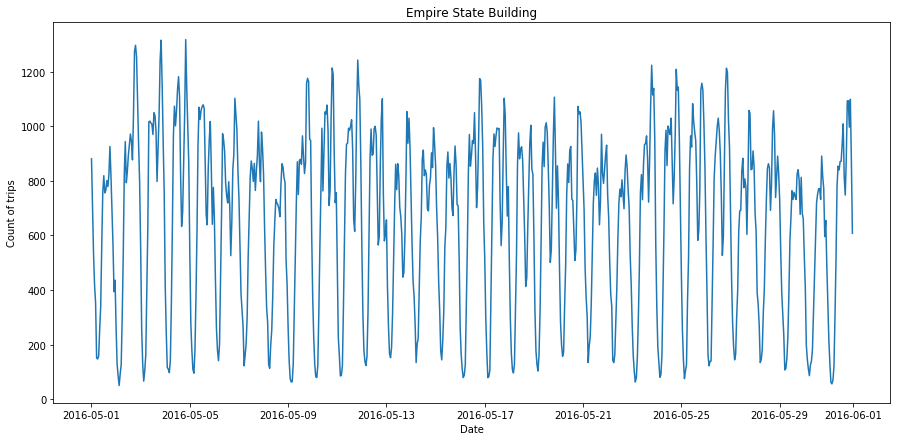

In [22]:
plt.figure(figsize=(15,7))
plt.plot(ESB.tpep_pickup_datetime,ESB.VendorID_Count)
plt.title("Empire State Building")
plt.ylabel("Count of trips")
plt.xlabel("Date")
plt.show()

## Теперь посчитаем, сколько всего должно быть записей:
24 часа * 31 день * 2500 ячеек

In [81]:
2500*24*31

1860000

In [57]:
data_1.shape

(141762, 20)

### Посчитаем количество регионо/часов без поездок

In [1]:
#Итого количество часов * регион =
1860000 - 141762



1718238

#### Количество часов и регионов без поездок: 1718238

In [89]:
# проверим сумму количества поездок, потому что более 90% регионо/часов без поездок
data_1.VendorID_Count.sum()

11626521

### Все верно

In [90]:
data_1.head()

,tpep_pickup_datetime,region,VendorID_Count,tpep_dropoff_datetime_Count,passenger_count_Count,trip_distance_Count,pickup_longitude_Count,pickup_latitude_Count,RatecodeID_Count,store_and_fwd_flag_Count,dropoff_longitude_Count,dropoff_latitude_Count,payment_type_Count,fare_amount_Count,extra_Count,mta_tax_Count,tip_amount_Count,tolls_amount_Count,improvement_surcharge_Count,total_amount_Count
0,2016-05-01,1015,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2016-05-01,1017,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2016-05-01,1029,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,2016-05-01,1030,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2016-05-01,1033,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
